<a href="https://colab.research.google.com/github/vlad-danaila/ml-cancer-detection/blob/master/Cancer_Detection_Ensable_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install sklearn matplotlib GPUtil

In [ ]:
!pip3 install "pillow<7"

In [ ]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html

**Download Data**

Mount my google drive, where the dataset is stored.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print(e)

Unzip the dataset into the folder "dataset".

In [ ]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

**Constants**

In [36]:
# TRAIN_PATH = '/content/dataset/data/train/'
# TEST_PATH = '/content/dataset/data/test/'
TRAIN_PATH = 'dataset/data/train/'
TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

# prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
prefix = 'Mobilenetv2 Tuning/'
CHACKPOINT_CROSS_ENTROPY_MODEL = prefix + 'checkpint densenet_baseline.tar'

**Imports**

In [2]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import statistics
import math

**Deterministic Measurements**

This statements help making the experiments reproductible by fixing the random seeds.

In [3]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Memory Stats**

In [4]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB
GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB


**Loading Data**

The dataset is structured in multiple small folders, ecah containing 7 images. The generator iterates through the folders and returns the category and 7 paths: one for each image in the folder.

In [5]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which loads 3 kinds of images: natural images, images taken through a green lens and images where the doctor aplied iodine solution (which gives a dark red colour). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [6]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [7]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [8]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [9]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [10]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [11]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [12]:
# x, y = next(iter(loader_train_simple_img))
# for i in range(7):
#   plot_predictions(x[i], y, y)

**Model**

In [13]:
def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier.out_features = 4
  model = model.cuda()
  return model

In [14]:
model_simple = t.nn.DataParallel(get_dense_net())

**Train & Evaluate**

Timer utility function. This is used to measure the execution speend.

In [15]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and e valuates it at the same time. It outputs the metrics recorder during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is imporved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [16]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': [],

      'mean_class_acc_train': [],
      'mean_class_acc_test': []  
  }

  best_mean_acc = 0
  
  loss_weights = t.tensor([1/4] * 4, device='cuda:0')
    
  try:  
    for epoch in range(epochs):
      timer_start()
      loss_fn = t.nn.CrossEntropyLoss(weight = loss_weights)
      # loss_fn = t.nn.CrossEntropyLoss()
      # loss_fn = FocalLoss(gamma = 2)
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      conf_matrix = np.zeros((4, 4))
      for x, y in loader_train:
        y_pred = model.forward(x)
        y_pred = y_pred.narrow(1, 0, 4)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
        conf_matrix += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      mean_class_acc = statistics.harmonic_mean(class_acc)
      errors = [1 - conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      errors_strong = [math.exp(100 * e) for e in errors]
      loss_weights = t.tensor([e / sum(errors_strong) for e in errors_strong], device = 'cuda:0')
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
      metrics['mean_class_acc_train'].append(mean_class_acc) 

      # Evaluate
      model.eval()
      with t.no_grad():
        conf_matrix_test = np.zeros((4, 4))
        for x, y in loader_test:
          y_pred = model.forward(x)
          y_pred = y_pred.narrow(1, 0, 4)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
          conf_matrix_test += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
        class_acc_test = [conf_matrix_test[i][i] / sum(conf_matrix_test[i]) for i in range(len(conf_matrix_test))]
        mean_class_acc_test = statistics.harmonic_mean(class_acc_test)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
        metrics['mean_class_acc_test'].append(mean_class_acc_test) 
      
      if metrics['mean_class_acc_test'][-1] > best_mean_acc:
        best_mean_acc = metrics['mean_class_acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} mean class acc {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['mean_class_acc_test'][-1], metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [17]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

In [18]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [19]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['mean_class_acc_test']).argmax()
    print('Best mean class accuracy :', metrics['mean_class_acc_test'][index_max])
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['mean_class_acc_train'], metrics['mean_class_acc_test'], 'Mean Class Accuracy (lr = {})'.format(learn_rate), 'Mean Class Accuracy')
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

Perform actual training

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 mean class acc 0.19147233043385453 acc 0.3208333333333333 prec 0.22377873563218392 rec 0.14149305555555558 f 0.16360423589374906 minutes 0.4056531031926473
Epoch 2 mean class acc 0.2937062937062937 acc 0.37916666666666665 prec 0.28878586691086694 rec 0.18541666666666667 f 0.21768930460263008 minutes 0.27224220434824625
Epoch 3 mean class acc 0.31660552887342586 acc 0.44166666666666665 prec 0.2810896260997068 rec 0.23680555555555557 f 0.24126068316591892 minutes 0.2717676599820455
Epoch 4 mean class acc 0.3705103969754253 acc 0.48750000000000004 prec 0.3048576038159372 rec 0.26145833333333335 f 0.268346051276993 minutes 0.27103434403737386
Epoch 5 mean class acc 0.3884856630824373 acc 0.475 prec 0.29162449641272725 rec 0.2543402777777778 f 0.26260211685405993 minutes 0.27483656803766887
Epoch 6 mean class acc 0.42331983303074033 acc 0.4833333333333334 prec 0.31011855635888985 rec 0.2598958333333334 f 0.2758606225949006 minutes 0.2749935547510783
Epoch 7 mean class acc 0.44171779

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14 mean class acc 0.4143407122232916 acc 0.4583333333333333 prec 0.31921758419036095 rec 0.24583333333333335 f 0.27267236675661805 minutes 0.2709189216295878
Epoch 15 mean class acc 0.39923242384484253 acc 0.47500000000000003 prec 0.31203108284196646 rec 0.2595486111111111 f 0.27041353177803806 minutes 0.2718867262204488
Epoch 16 mean class acc 0.3824067558057706 acc 0.5166666666666666 prec 0.3286922833649589 rec 0.2725694444444444 f 0.2851283067900823 minutes 0.27376095453898114
Epoch 17 mean class acc 0.375 acc 0.5416666666666667 prec 0.359827196382429 rec 0.2798611111111111 f 0.2996416610744914 minutes 0.2718637704849243
Epoch 18 mean class acc 0.36304700162074555 acc 0.4958333333333333 prec 0.3680932971014493 rec 0.2767361111111111 f 0.3087233685986167 minutes 0.2715666810671488
Epoch 19 mean class acc 0.4485381089233546 acc 0.4666666666666667 prec 0.3390378541307334 rec 0.2557291666666667 f 0.2867193661642719 minutes 0.27407594124476115
Epoch 20 mean class acc 0.404599179866

Epoch 66 mean class acc 0.5718502183961665 acc 0.6166666666666667 prec 0.506430002828308 rec 0.3936342592592593 f 0.4392257690453245 minutes 0.2728397329648336
Epoch 67 mean class acc 0.544394212454663 acc 0.5874999999999999 prec 0.5163221839161412 rec 0.36307870370370365 f 0.41950086785473106 minutes 0.27193989356358844
Epoch 68 mean class acc 0.506896551724138 acc 0.6416666666666666 prec 0.43125087953841823 rec 0.35052083333333334 f 0.3790902464028894 minutes 0.27032503684361775
Epoch 69 mean class acc 0.515894610677713 acc 0.6333333333333333 prec 0.43047437093982605 rec 0.3486111111111111 f 0.3767673304708994 minutes 0.2717597683270772
Epoch 70 mean class acc 0.528246591286997 acc 0.6333333333333333 prec 0.4498595018815607 rec 0.35173611111111114 f 0.3867445423267807 minutes 0.2725493868192037
Epoch 71 mean class acc 0.5427058870357839 acc 0.6416666666666667 prec 0.458219115497076 rec 0.35468750000000004 f 0.3906072828927828 minutes 0.2719690759976705
Epoch 72 mean class acc 0.53837

Epoch 117 mean class acc 0.5506072874493927 acc 0.6333333333333334 prec 0.4262505066626133 rec 0.3315972222222222 f 0.36529730143600225 minutes 0.27195233503977456
Epoch 118 mean class acc 0.5676736265363542 acc 0.6333333333333334 prec 0.41471832968926 rec 0.32534722222222223 f 0.3588133787726441 minutes 0.27291166385014853
Epoch 119 mean class acc 0.5529302756543896 acc 0.6208333333333333 prec 0.4120068062465451 rec 0.3208333333333333 f 0.3539966163857418 minutes 0.27214190165201824
Epoch 120 mean class acc 0.5409336003697427 acc 0.6125 prec 0.4849599939613527 rec 0.36944444444444446 f 0.4095301242949451 minutes 0.27253423929214476
Epoch 121 mean class acc 0.5557050769303157 acc 0.6291666666666668 prec 0.4649032167214712 rec 0.3458333333333334 f 0.3864529307326245 minutes 0.27250881989796955
Epoch 122 mean class acc 0.5284085175093349 acc 0.6 prec 0.48654513888888895 rec 0.3616898148148148 f 0.40514770723104054 minutes 0.27170577049255373
Epoch 123 mean class acc 0.5409735744089013 ac

Epoch 169 mean class acc 0.5140802875973637 acc 0.6041666666666667 prec 0.44825708061002173 rec 0.3340277777777778 f 0.3726207101434305 minutes 0.27185699542363484
Epoch 170 mean class acc 0.5260165616116673 acc 0.6124999999999999 prec 0.44918332320008103 rec 0.3387152777777778 f 0.3770094631399362 minutes 0.27116043170293175
Epoch 171 mean class acc 0.5081184336198663 acc 0.5958333333333333 prec 0.4206405515422543 rec 0.3157986111111111 f 0.35152616662104097 minutes 0.2712273319562276
Epoch 172 mean class acc 0.5123300299608204 acc 0.5916666666666667 prec 0.42145412457912457 rec 0.3144097222222223 f 0.3515043874493962 minutes 0.2716429829597473
Epoch 173 mean class acc 0.5135135135135135 acc 0.6000000000000001 prec 0.42305148555148553 rec 0.3182291666666667 f 0.35302098296387646 minutes 0.2714738408724467
Epoch 174 mean class acc 0.48508903668740616 acc 0.6166666666666666 prec 0.44883733164983164 rec 0.3376736111111111 f 0.3721935958778064 minutes 0.27299033403396605
Epoch 175 mean cl

Epoch 220 mean class acc 0.5103756963954097 acc 0.6125 prec 0.4177187412222624 rec 0.32048611111111114 f 0.35271850640270713 minutes 0.2716917395591736
Epoch 221 mean class acc 0.5134449518011162 acc 0.6000000000000001 prec 0.397794937805483 rec 0.309375 f 0.3412815612934268 minutes 0.27130881945292157
Epoch 222 mean class acc 0.51055167266065 acc 0.6041666666666667 prec 0.402478571838092 rec 0.3085069444444445 f 0.34079042776876983 minutes 0.28064477841059365
Epoch 223 mean class acc 0.5109435036288601 acc 0.6208333333333333 prec 0.41895721355968285 rec 0.3265625 f 0.35661367698034374 minutes 0.3361471136411031
Epoch 224 mean class acc 0.4932348952840139 acc 0.6125 prec 0.41954380436385086 rec 0.3222222222222222 f 0.3532889977113598 minutes 0.3098675529162089
Epoch 225 mean class acc 0.47421093148575827 acc 0.6041666666666667 prec 0.40335648148148145 rec 0.3050347222222223 f 0.3344858641402239 minutes 0.3087807099024455
Epoch 226 mean class acc 0.49791856242263266 acc 0.60833333333333

Epoch 272 mean class acc 0.5041482789055605 acc 0.6166666666666667 prec 0.41614452798663326 rec 0.32482638888888893 f 0.35408256802831917 minutes 0.4313036362330119
Epoch 273 mean class acc 0.52073802006143 acc 0.6125 prec 0.40960378127332 rec 0.32135416666666666 f 0.3525928672650418 minutes 0.36923785209655763
Epoch 274 mean class acc 0.5075528700906344 acc 0.6125 prec 0.40076754385964913 rec 0.3145833333333334 f 0.34246803119680114 minutes 0.3728647510210673
Epoch 275 mean class acc 0.5110814419225634 acc 0.6125 prec 0.4151166955033395 rec 0.32395833333333335 f 0.354227909224494 minutes 0.4061090548833211
Epoch 276 mean class acc 0.5142857142857142 acc 0.6125 prec 0.4403337890179995 rec 0.3427083333333334 f 0.37743757138185796 minutes 0.38494552771250407
Epoch 277 mean class acc 0.49733789161015524 acc 0.6041666666666667 prec 0.40091699388356117 rec 0.3102430555555556 f 0.33957954547824637 minutes 0.31674145460128783
Epoch 278 mean class acc 0.49843469077284785 acc 0.6000000000000001

Epoch 324 mean class acc 0.4836107633258759 acc 0.5875 prec 0.3942843219159009 rec 0.30121527777777785 f 0.33185523965275066 minutes 0.28283456961313885
Epoch 325 mean class acc 0.4840616668598586 acc 0.6000000000000001 prec 0.40438734370559826 rec 0.31701388888888893 f 0.3446316205589759 minutes 0.28645460605621337
Epoch 326 mean class acc 0.518763723041904 acc 0.5958333333333333 prec 0.41262583440999134 rec 0.3154513888888889 f 0.3509085000448715 minutes 0.2882947206497192
Epoch 327 mean class acc 0.4975054585152838 acc 0.5833333333333334 prec 0.4056677129916294 rec 0.31024305555555554 f 0.3427650908119658 minutes 0.284160586198171
Epoch 328 mean class acc 0.489073555375609 acc 0.5916666666666667 prec 0.4108955208068481 rec 0.3151041666666667 f 0.3466852191290844 minutes 0.2846229553222656
Epoch 329 mean class acc 0.5030852994555354 acc 0.6000000000000001 prec 0.4074647402820778 rec 0.31909722222222225 f 0.34849480032875163 minutes 0.2883136749267578
Epoch 330 mean class acc 0.512596

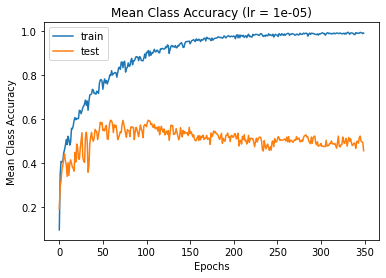

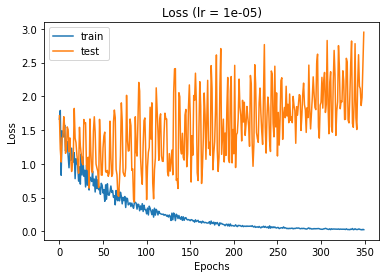

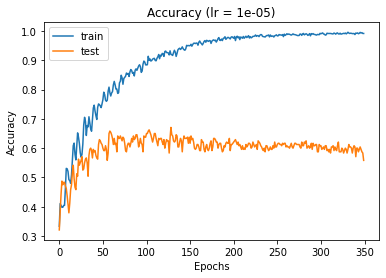

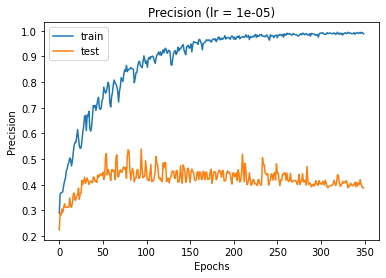

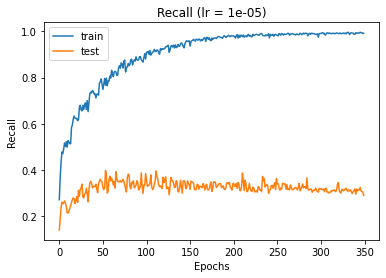

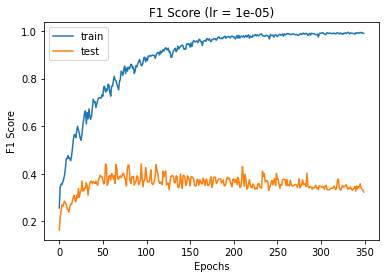

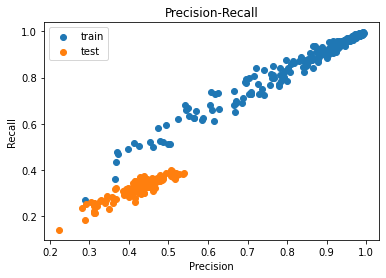

In [20]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'wce_dense_net', [(350, 1e-5)])

In [25]:
checkpoint = t.load('checkpint wce_dense_net.tar')
model_simple.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [31]:
def calculate_class_acc_for_test_set(model):
  model.eval()
  with t.no_grad():
    conf_matrix = np.zeros((4, 4))
    for x, y in loader_test_simple_img:
      y_pred = model.forward(x)
      y_pred = y_pred.narrow(1, 0, 4)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      cm = sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      conf_matrix += cm
    print('Confusion matrix:\n', conf_matrix)
    class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
    print('Class acc:\n', class_acc)
    return class_acc

def plot_class_acc(class_acc):
  plt.bar(list(range(4)), class_acc, align='center', alpha=0.5)
  plt.xticks(list(range(4)), list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.savefig('AccPerClass.pdf', dpi = 300, format = 'pdf')
  plt.show()

def plot_class_acc_comparison(class_acc_1, class_acc_2, title_1, title_2):
  width = .3
  plt.bar(list(range(4)), class_acc_1, width, alpha=0.5, color = 'green', label = title_1)
  plt.bar(np.array(list(range(4))) + width, class_acc_2, width, alpha=0.5, color = 'blue', label = title_2)
  plt.xticks(np.array(list(range(4))) + width/2, list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.savefig('ClassAccCompareDenseNet.pdf', dpi = 300, format = 'pdf')
  plt.show()

Confusion matrix:
 [[51.  1.  5.  3.]
 [20. 27. 13.  0.]
 [ 9. 15. 28.  8.]
 [ 0.  3.  6. 51.]]
Class acc:
 [0.85, 0.45, 0.4666666666666667, 0.85]


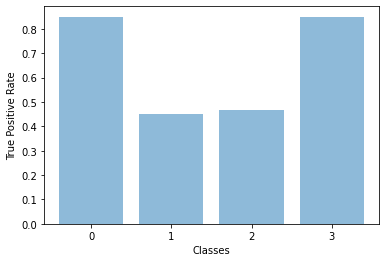

In [32]:
class_acc = calculate_class_acc_for_test_set(model_simple)
plot_class_acc(class_acc)

Confusion matrix:
 [[52.  3.  4.  1.]
 [29. 24.  7.  0.]
 [19. 15. 20.  6.]
 [ 1.  7. 12. 40.]]
Class acc:
 [0.8666666666666667, 0.4, 0.3333333333333333, 0.6666666666666666]


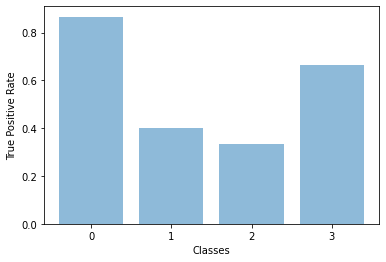

In [37]:
model_without_wl = t.nn.DataParallel(get_dense_net().cuda())
checkpoint_without_wl = t.load(CHACKPOINT_CROSS_ENTROPY_MODEL)
model_without_wl.load_state_dict(checkpoint_without_wl['model'])
class_acc_no_wl = calculate_class_acc_for_test_set(model_without_wl)
plot_class_acc(class_acc_no_wl)

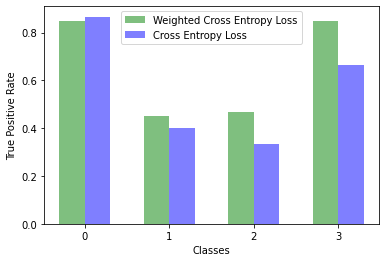

In [38]:
plot_class_acc_comparison(class_acc, class_acc_no_wl, 'Weighted Cross Entropy Loss', 'Cross Entropy Loss')